In [1]:
import numpy as np
from aeon.datasets import load_classification
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
from models import Models
from morph import Morph
from sklearn.preprocessing import LabelEncoder

In [3]:
ECG_datasets = ['AtrialFibrillation', 'CardiacArrhythmia', 'CinCECGTorso',
                'ECG200', 'ECG5000', 'ECGFiveDays', 'NonInvasiveFetalECGThorax1',
                'NonInvasiveFetalECGThorax2', 'StandWalkJump', 'TwoLeadECG','NerveDamage', 'MedicalImages']


df_name = 'ECG200'
X, y = load_classification(df_name)
print("Shape of X = ", X.shape)

le = LabelEncoder()
y = le.fit_transform(y)
print(f'Classes: {np.unique(y)}')

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Shape of X =  (200, 1, 96)
Classes: [0 1]


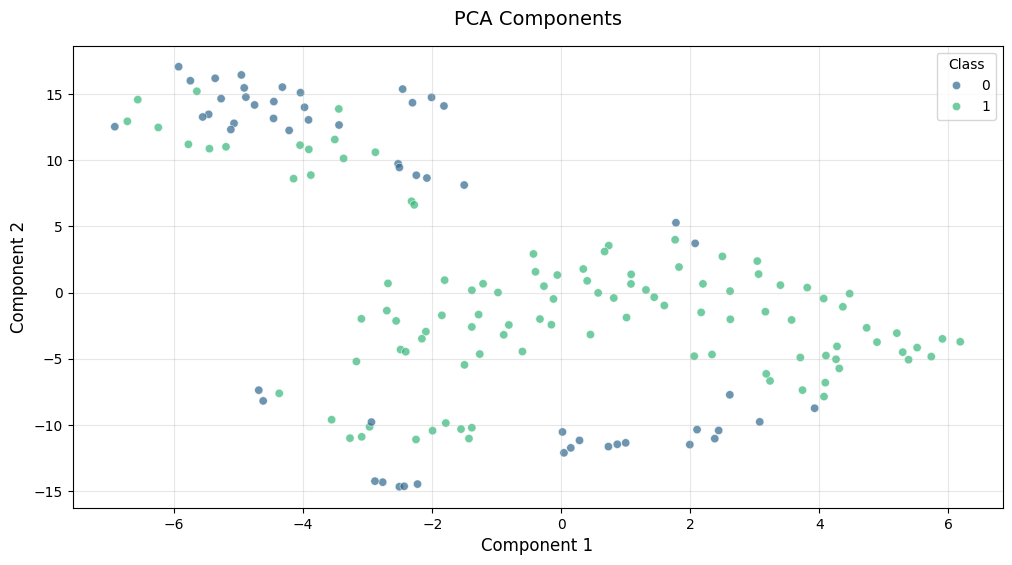

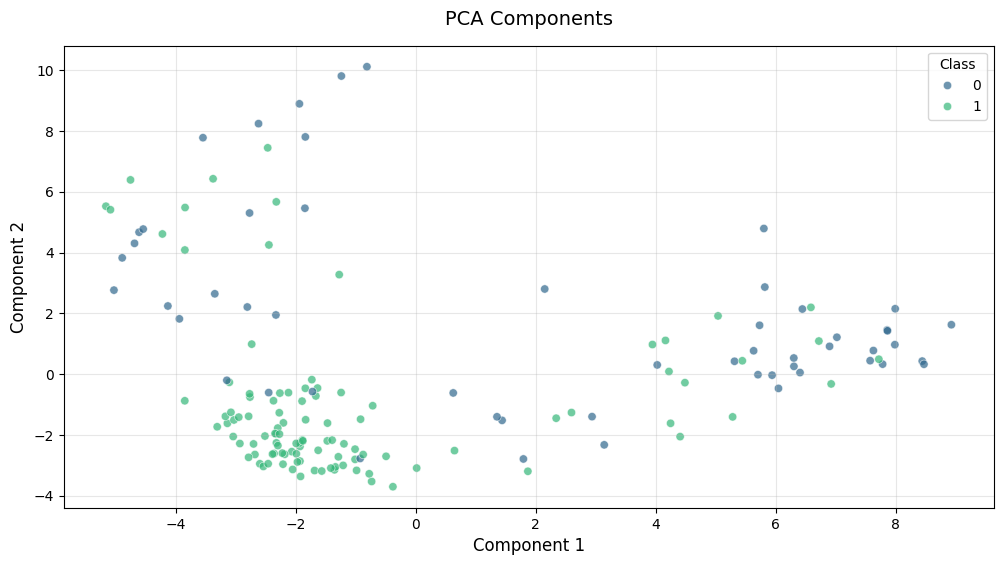

In [4]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

def getTSNE(X, n_components=2):
    tsne = TSNE(n_components=n_components)
    X_tsne = tsne.fit_transform(X)
    return X_tsne
    
def getPCA(X, n_components=2):
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X)
    return X_pca

def plot_components(X, y):
    plt.figure(figsize=(12, 6))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=y, palette='viridis', alpha=0.7)
    plt.title('PCA Components', fontsize=14, pad=15)
    plt.xlabel('Component 1', fontsize=12)
    plt.ylabel('Component 2', fontsize=12)
    plt.grid(True, alpha=0.3)
    plt.legend(title='Class')
    plt.show()

X_tsne = getTSNE(X_train.squeeze(axis=1), 2)
plot_components(X_tsne, y_train)

X_pca = getPCA(X_train.squeeze(axis=1), 2)
plot_components(X_pca, y_train)

In [ ]:
from aeon.datasets import load_classification
from sklearn.preprocessing import LabelEncoder
#'NonInvasiveFetalECGThorax1'

ECG_datasets = ['AtrialFibrillation', 'CardiacArrhythmia', 'CinCECGTorso',
                'ECG200', 'ECG5000', 'ECGFiveDays',
                'StandWalkJump', 'TwoLeadECG','NerveDamage', 'MedicalImages']

# Use a dictionary instead of a list to track sizes
dataset_sizes = {}

for df_name in ECG_datasets:
    try:
        X, y = load_classification(df_name)
        le = LabelEncoder()
        y = le.fit_transform(y)

        
        
        # Store the dataset size in the dictionary
        dataset_sizes[df_name] = X.shape[0]
    except:
        print(f'{df_name} Dataset Not Available')
        continue

# Sort the dictionary by size (from smallest to largest)
sorted_datasets = dict(sorted(dataset_sizes.items(), key=lambda item: item[1]))

# Print the sorted datasets with their sizes
for dataset, size in sorted_datasets.items():
    print(f"{dataset}: {size} samples")

CardiacArrhythmia Dataset Not Available
StandWalkJump: 27 samples
AtrialFibrillation: 30 samples
ECG200: 200 samples
NerveDamage: 204 samples
ECGFiveDays: 884 samples
MedicalImages: 1141 samples
TwoLeadECG: 1162 samples
CinCECGTorso: 1420 samples
ECG5000: 5000 samples


In [ ]:
import numpy as np
from aeon.datasets import load_classification
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd
from collections import Counter

from source.models import Models
from source.morph import Morph

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

#sorted_datasets = ['ECG200']

# Initialize variables to store results
all_results = {}
results_array = np.empty((0, 9))  # Initialize an empty NumPy array with 9 columns

# Loop through each dataset
for df_name in sorted_datasets:
    results = {}

    try:
        # Load dataset
        X, y = load_classification(df_name)
        le = LabelEncoder()
        y = le.fit_transform(y)
    except Exception as e:
        print(f'{df_name}: Dataset Not Available - {str(e)}')
        continue

    # Skip multivariate time series
    if X.shape[1] != 1:
        print(f'{df_name}: Multivariate Time Series - Skipping')
        continue

    print('-' * 60)
    print(f'Processing Dataset: {df_name}')

    # Split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Calculate dataset size and number of classes
    ts_length = X_train.shape[2]
    df_size = X_train.shape[0]
    n_classes = len(np.unique(y))  # Total number of classes

    # Count the frequency of each class
    class_counts = Counter(y)
    num_classes = len(class_counts)

    # Train Models
    start = time.time()
    lstm = Models('lstm', X_train, y_train)
    lstm.train_lstm()
    catch = Models('catch22', X_train, y_train)
    catch.train_catch22()
    rocket = Models('rocket', X_train, y_train)
    rocket.train_rocket()

    training_time = time.time()
    print(f'Training time: {training_time - start}')

    # Evaluate models
    models = (lstm, catch, rocket)
    acc = {}
    for m in models:
        pred, _ = m.predict(X_test)
        acc[m.model_name] = accuracy_score(pred, y_test)

    # Loop through each class
    for c in np.unique(y):
        start_class = time.time()
        print(f'Processing Class: {c}')

        class_perc = round(num_classes[c]/df_size *100, 2)

        # Perform morphing calculations
        mor = Morph(X_test, y_test, c)
        mor.get_DTWGlobalBorderline(perc_samples=0.1)
        res = mor.Binary_MorphingCalculater(models)

        end_class = time.time()
        print(f'Total Class {c} run time: {end_class - start_class}')

        # Store results for the class
        results[c] = res


        class_decoed = le.inverse_transform([c])[0]
        print(class_decoed)

        # Append results to NumPy array
        for model in res.keys():
            data = res[model]['metrics']
            line = np.array([[df_name, df_size, ts_length, n_classes, class_decoed, class_perc, model, data['mean'], data['std'], acc[model]]])
            results_array = np.vstack((results_array, line))
        

    # Save results for the current dataset
    file_name = f'results/{df_name}.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump(results, f)

    # Add results to all_results
    all_results[df_name] = results

    # Clean ups
    del models, lstm, catch, rocket, results

    # Convert NumPy array to Pandas DataFrame
    columns = ['dataset', 'df_size', 'ts_length', 'n_classes', 'class', 'class_perc', 'model', 'mean', 'std', 'model_acc']
    dataframe = pd.DataFrame(results_array, columns=columns)
    # Save results to CSV
    dataframe.to_csv('results/experiments.csv', index=False)

    # Save all results to a single pickle file
    with open('results/pickles/experiments.pkl', 'wb') as f:
        pickle.dump(all_results, f)

print('All results saved successfully!')

StandWalkJump: Multivariate Time Series - Skipping
AtrialFibrillation: Multivariate Time Series - Skipping
------------------------------------------------------------
Processing Dataset: ECG200
Training time: 10.612311124801636
Processing Class: 0


100%|██████████| 35/35 [00:17<00:00,  1.96it/s]


Total Class 0 run time: 17.90744161605835
-1
Processing Class: 1


100%|██████████| 35/35 [00:17<00:00,  1.98it/s]


Total Class 1 run time: 17.691431522369385
1
------------------------------------------------------------
Processing Dataset: NerveDamage
Training time: 21.497586011886597
Processing Class: 0


100%|██████████| 21/21 [02:14<00:00,  6.41s/it]


Total Class 0 run time: 135.90534853935242
0
Processing Class: 1


100%|██████████| 39/39 [03:56<00:00,  6.07s/it]


Total Class 1 run time: 239.79119753837585
1
Processing Class: 2


100%|██████████| 42/42 [04:06<00:00,  5.87s/it]


Total Class 2 run time: 249.67401599884033
2
------------------------------------------------------------
Processing Dataset: ECGFiveDays
Training time: 23.895554780960083
Processing Class: 0


100%|██████████| 783/783 [08:51<00:00,  1.47it/s]


Total Class 0 run time: 532.3992867469788
1
Processing Class: 1


100%|██████████| 783/783 [09:15<00:00,  1.41it/s]


Total Class 1 run time: 555.9695224761963
2
------------------------------------------------------------
Processing Dataset: MedicalImages
Training time: 34.347697496414185
Processing Class: 0


100%|██████████| 474/474 [04:50<00:00,  1.63it/s]


Total Class 0 run time: 291.1142485141754
1
Processing Class: 1


100%|██████████| 1284/1284 [11:53<00:00,  1.80it/s]


Total Class 1 run time: 714.1943776607513
10
Processing Class: 2


100%|██████████| 341/341 [02:49<00:00,  2.01it/s]


Total Class 2 run time: 170.07342195510864
2
Processing Class: 3


100%|██████████| 281/281 [02:26<00:00,  1.92it/s]


Total Class 3 run time: 146.65316820144653
3
Processing Class: 4


100%|██████████| 68/68 [00:34<00:00,  1.96it/s]


Total Class 4 run time: 34.70427083969116
4
Processing Class: 5


100%|██████████| 219/219 [01:55<00:00,  1.90it/s]


Total Class 5 run time: 115.47943067550659
5
Processing Class: 6


100%|██████████| 90/90 [00:48<00:00,  1.86it/s]


Total Class 6 run time: 48.403411865234375
6
Processing Class: 7


100%|██████████| 198/198 [01:47<00:00,  1.84it/s]


Total Class 7 run time: 107.87243151664734
7
Processing Class: 8


100%|██████████| 112/112 [00:59<00:00,  1.88it/s]


Total Class 8 run time: 59.626023054122925
8
Processing Class: 9


100%|██████████| 321/321 [02:53<00:00,  1.85it/s]


Total Class 9 run time: 174.23706555366516
9
------------------------------------------------------------
Processing Dataset: TwoLeadECG
Training time: 27.97084140777588
Processing Class: 0


100%|██████████| 1357/1357 [10:38<00:00,  2.13it/s]


Total Class 0 run time: 639.2493703365326
1
Processing Class: 1


100%|██████████| 1357/1357 [10:53<00:00,  2.08it/s]


Total Class 1 run time: 654.4008662700653
2
------------------------------------------------------------
Processing Dataset: CinCECGTorso
Training time: 117.02495527267456
Processing Class: 0


  2%|▏         | 36/1581 [04:11<3:00:08,  7.00s/it]


KeyboardInterrupt: 

In [7]:
ECG_datasets = ['AtrialFibrillation', 'CardiacArrhythmia', 'CinCECGTorso',
                'ECG200', 'ECG5000', 'ECGFiveDays', 'NonInvasiveFetalECGThorax1',
                'StandWalkJump', 'TwoLeadECG','NerveDamage', 'MedicalImages']

for df_name in sorted_datasets:
    results = {}

    try:
        X, y = load_classification(df_name)
        le = LabelEncoder()
        y = le.fit_transform(y)
    except:
        print(df_name, 'Dataset Not Available')
        continue


    if X.shape[1] != 1:
        print(df_name, 'Multivariate Time Series')
        continue

    print('-'*60)
    print(df_name)
    print(X.shape)
    print(np.unique(y))

StandWalkJump Multivariate Time Series
AtrialFibrillation Multivariate Time Series
------------------------------------------------------------
ECG200
(200, 1, 96)
[0 1]
------------------------------------------------------------
NerveDamage
(204, 1, 1500)
[0 1 2]
------------------------------------------------------------
ECGFiveDays
(884, 1, 136)
[0 1]
------------------------------------------------------------
MedicalImages
(1141, 1, 99)
[0 1 2 3 4 5 6 7 8 9]
------------------------------------------------------------
TwoLeadECG
(1162, 1, 82)
[0 1]
------------------------------------------------------------
CinCECGTorso
(1420, 1, 1639)
[0 1 2 3]
------------------------------------------------------------
NonInvasiveFetalECGThorax1
(3765, 1, 750)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
------------------------------------------------------------
ECG5000
(5000, 1, 140)
[0 1 2 3 4]


In [ ]:
import numpy as np
from aeon.datasets import load_classification
from sklearn.model_selection import train_test_split
import pickle
import pandas as pd

from source.models import Models
from source.morph import Morph

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

df = []
all_results = {}
for df_name in sorted_datasets:
    results = {}

    try:
        X, y = load_classification(df_name)
        le = LabelEncoder()
        y = le.fit_transform(y)
    except:
        print(df_name, 'Dataset Not Available')
        continue


    if X.shape[1] != 1:
        print(df_name, 'Multivariate Time Series')
        continue

    print('-'*60)
    print(df_name)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    
    ts_length = X_train.shape[2]
    df_size = X_train.shape[0]
    n_classes = len(np.unique(y))

    # Train Models
    start = time.time()
    lstm = Models('lstm', X_train, y_train)
    lstm.train_lstm()
    catch = Models('catch22', X_train, y_train)
    catch.train_catch22()
    rocket = Models('rocket', X_train, y_train)
    rocket.train_rocket()

    training_time = time.time()
    print('Training time: ', training_time-start)

    models = (lstm, catch, rocket)
    acc = {}
    for m in models:
        pred,_ = m.predict(X_test)
        acc[m.model_name] = accuracy_score(pred, y_test)

    # Loop through class
    for c in np.unique(y):
        start = time.time()
        # claculate the class percentage
        num_classes = len(np.unique(y))
        class_perc = round(num_classes/len(y) *100, 2)

        res = {}
        print(c)
        mor = Morph(X_test, y_test, c)
        mor.get_DTWGlobalBorderline(perc_samples=0.1)

        res = mor.Binary_MorphingCalculater(models)
                  
        end_class = time.time()
        print(f'Total Class {c} run time: {end_class-training_time}')

        results[c] = res
        del res
    
    file_name = 'results/' + df_name + '.pkl'
    with open(file_name, 'wb') as f:
        pickle.dump(results, f)

    all_results[df_name] = results
    with open('results/experiments.pkl', 'wb') as f:
        pickle.dump(all_results, f)

    del models, lstm, catch, rocket, results

    for ds in all_results.keys():
        for c in all_results[ds].keys():
            for model in all_results[ds][c].keys(): 
                data = all_results[ds][c][model]['metrics']
                line = [df_name, df_size, ts_length, n_classes, c, class_perc, model, data['mean'], data['std'], acc[model]]
                df.append(line)

    # save to csv
    columns = ['dataset', 'df_size', 'ts_length', 'n_classes', 'class', 'class_perc', 'model', 'mean', 'std', 'model_acc']
    dataframe = pd.DataFrame(df, columns=columns)
    dataframe.to_csv('results/experiments_cont.csv', index=False)

StandWalkJump Multivariate Time Series
AtrialFibrillation Multivariate Time Series
------------------------------------------------------------
ECG200


KeyboardInterrupt: 

In [5]:
file_name = 'results/' + df_name + '.pkl'
with open(file_name, 'wb') as f:
    pickle.dump(results, f)

all_results[df_name] = results
with open('results/experiments.pkl', 'wb') as f:
    pickle.dump(all_results, f)

for ds in all_results.keys():
    for c in all_results[ds].keys():
        for model in all_results[ds][c].keys(): 
            data = all_results[ds][c][model]['metrics']
            line = [df_name, c, model, data['mean'], data['std'], acc[model], X_test.shape[2]]
            df.append(line)

# save to csv
columns = ['dataset', 'class', 'model', 'mean', 'std', 'model_acc', 'ts_lenght']
dataframe = pd.DataFrame(df, columns=columns)
dataframe.to_csv('results/experiments.csv', index=False)


## NonInvasiveFetalECGThorax1 

- 42 Different Classes (1h-2h run/per class)

In [ ]:
print(np.unique(y_test))

from collections import Counter
print(Counter(y))

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41]
Counter({6: 98, 4: 97, 21: 96, 37: 96, 7: 95, 28: 94, 24: 94, 38: 94, 27: 94, 36: 93, 39: 93, 35: 93, 1: 92, 31: 91, 40: 91, 11: 91, 9: 91, 34: 91, 29: 91, 3: 90, 17: 90, 12: 90, 32: 90, 25: 90, 13: 89, 5: 89, 19: 89, 41: 88, 10: 88, 22: 87, 15: 87, 30: 87, 16: 87, 14: 86, 23: 86, 26: 85, 20: 85, 33: 85, 8: 85, 0: 84, 18: 78, 2: 75})
753
